# Preprocess

In [1]:
# Import the necessary libraries.
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pysiology
from tqdm.notebook import tqdm

Thank you for using Pysiology. If you use it in your work, please cite:
Gabrieli G., Azhari A., Esposito G. (2020) PySiology: A Python Package for Physiological Feature Extraction. In: Esposito A., Faundez-Zanuy M., Morabito F., Pasero E. (eds) Neural Approaches to Dynamics of Signal Exchanges. Smart Innovation, Systems and Technologies, vol 151. Springer, Singapore. https://doi.org/10.1007/978-981-13-8950-4_35


In [2]:
# Load the sharpwave data from files, and ignore lines with missing values.
data_dir = 'data'
data_names = [f'20151026_{i}' for i in range(1, 1001)]
num_seqs = len(data_names)

data: list[npt.NDArray[np.float64]] = []

for i in tqdm(range(num_seqs), desc='Loading data'):
    # Load data from file
    data_path = os.path.join(data_dir, data_names[i])
    # Ignore the row if data is missing
    data.append(np.genfromtxt(data_path, invalid_raise=False))

Loading data:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_4576\211607532.py:12: ConversionWarning: Some errors were detected !
    Line #44998 (got 3 columns instead of 4)
    Line #44999 (got 3 columns instead of 4)
    Line #45000 (got 3 columns instead of 4)
  data.append(np.genfromtxt(data_path, invalid_raise=False))


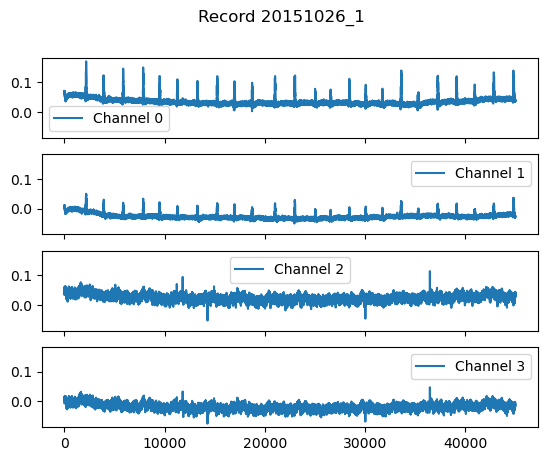

In [3]:
# Plot the first record
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
for i, ax in enumerate(axs):
    ax.plot(data[0][:, i], label=f'Channel {i}')
    ax.legend()

plt.suptitle('Record 20151026_1')
plt.show()

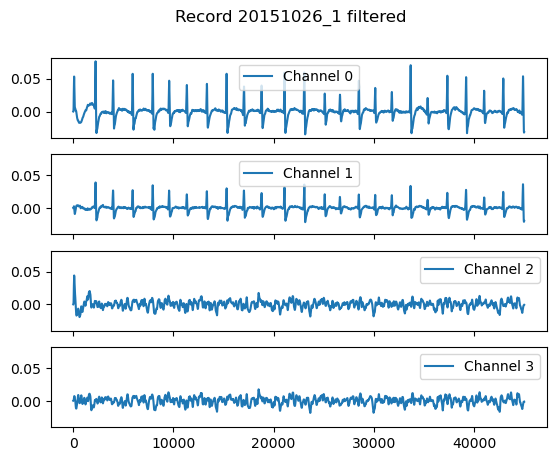

In [4]:
# Plot the filtered first record
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
for i, ax in enumerate(axs):
    channel_filtered = pysiology.electrocardiography.butter_lowpass_filter(data[0][:, i], 30, 3000, 5)
    channel_filtered = pysiology.electrocardiography.butter_highpass_filter(channel_filtered, 1, 3000, 5)
    ax.plot(channel_filtered, label=f'Channel {i}')
    ax.legend()

plt.suptitle('Record 20151026_1 filtered')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

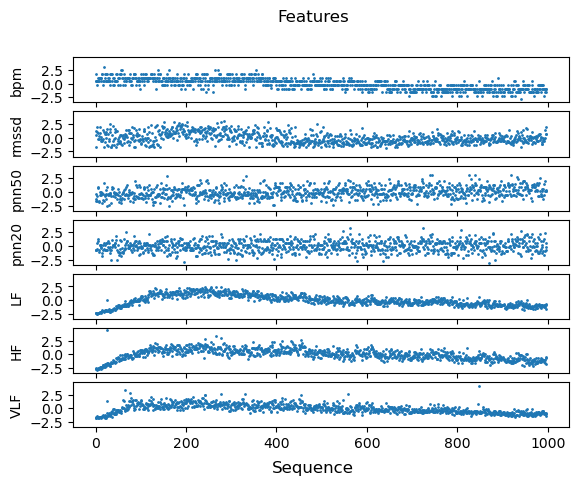

In [5]:
# Extract features from the data after combining the four channels, and applying a bandpass filter.
time_feature_names = ['bpm', 'rmssd', 'pnn50', 'pnn20'] 
time_features = np.zeros((len(data), 4), dtype=np.float64)
freq_feature_names = ['LF', 'HF', 'VLF']
freq_features = np.zeros((len(data), 3), dtype=np.float64)

for i in tqdm(range(num_seqs)):
    # Merging channels into one
    avg = np.mean(data[i], axis=1)
    # Filter the signal
    filtered = pysiology.electrocardiography.butter_lowpass_filter(
        avg, 30, 3000, 5)
    filtered = pysiology.electrocardiography.butter_highpass_filter(
        filtered, 1, 3000, 5)
    # Calculate time domain features
    result = pysiology.electrocardiography.analyzeECG(filtered, 3000, preprocessing=False,
                                                    freqAnalysis=False,
                                                    freqAnalysisFiltered=False)
    for j, name in enumerate(time_feature_names):
        time_features[i, j] = result[name]

    # Calculate frequency domain features
    result = pysiology.electrocardiography.getFrequencies(filtered, 3000,
                                                        # Low range
                                                        llc=3, ulc=10,
                                                        # High range
                                                        lhc=10, uhc=30,
                                                        # Very low range
                                                        lvlc=1, hvlc=3)
    for j, name in enumerate(freq_feature_names):
        freq_features[i, j] = result[name]

features = np.concatenate((time_features, freq_features), axis=1)
feature_names = time_feature_names + freq_feature_names

# Normalize data
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

# Remove outliers
mask = np.ones(features.shape[0], dtype=bool)
for i in range(features.shape[1]):
    mask[features[:, i] > 5] = False
features = features[mask]

# Plot data
fig = plt.figure()
for i, ax in enumerate(fig.subplots(features.shape[1], 1, sharex=True, sharey=True).flatten()):
    ax.scatter(range(features.shape[0]), features[:, i], s=1)
    ax.set_ylabel(feature_names[i])

fig.suptitle('Features')
fig.supxlabel('Sequence')
plt.show()

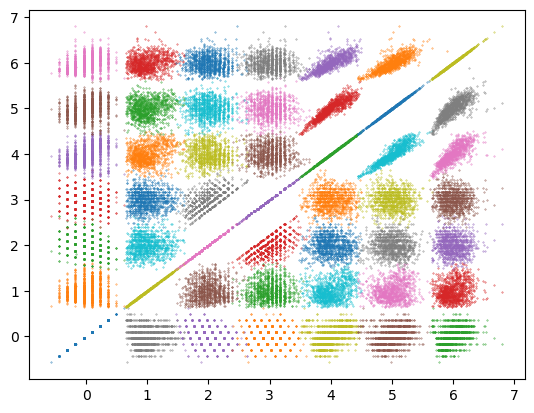

In [6]:
# Plot the correlation matrix
for i, j in np.ndindex((features.shape[1], features.shape[1])):
    plt.scatter(features[:, i]/5+i, features[:, j]/5+j, s=0.1)

plt.show()

In [7]:
# Save the features to a file
np.savetxt('features.txt', features)